<a href="https://colab.research.google.com/github/elariekerboull/master_uppsala/blob/main/Exercise_10_real_time_noise_rejection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D

You can estimate how fast a network prediction can be calculated by calculating the number of floating point operations performed in the network. This function is a handy tool to do it. Use it like this `print(get_flops(my_model))` where `my_model` is your KERAS neural network model.

In [22]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import tensorflow as tf
######################################Calculate FLOPS##########################################
def get_flops(model):
    '''
    Calculate FLOPS
    Parameters
    ----------
    model : tf.keras.Model
        Model for calculating FLOPS.

    Returns
    -------
    flops.total_float_ops : int
        Calculated FLOPS for the model
    '''

    batch_size = 1
    #input_shape = [batch_size] + model.inputs[0].shape[1:]

    #real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + list(model.inputs[0].shape[1:]), model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

Downloading the data (1 signal data file and 5 noise data files)

In [4]:
# download data file that contains signal events
if not os.path.exists("trimmed100_data_signal_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq


Downloading...
From: https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq
To: /content/trimmed100_data_signal_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 130MB/s]


In [5]:
# download data file that contains noise events
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0001.npy"):
  !gdown https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0002.npy"):
  !gdown https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0003.npy"):
  !gdown https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0004.npy"):
  !gdown https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0005.npy"):
  !gdown https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx

Downloading...
From: https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
To: /content/trimmed100_data_noise_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
To: /content/trimmed100_data_noise_3.6SNR_1ch_0001.npy
100% 80.0M/80.0M [00:00<00:00, 88.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
To: /content/trimmed100_data_noise_3.6SNR_1ch_0002.npy
100% 80.0M/80.0M [00:00<00:00, 98.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
To: /content/trimmed100_data_noise_3.6SNR_1ch_0003.npy
100% 80.0M/80.0M [00:00<00:00, 86.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
To: /content/trimmed100_data_noise_3.6SNR_1ch_0004.npy
100% 80.0M/80.0M [00:00<00:00, 170MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx
To: /c

Load the data into memory and combine it into one array.

In [6]:
# load signal and noise data set into memory
noise = np.load("trimmed100_data_noise_3.6SNR_1ch_0000.npy")
for i in range(1,5):
  noise = np.vstack((noise,np.load(f"trimmed100_data_noise_3.6SNR_1ch_000{i}.npy")))
signal = np.load("trimmed100_data_signal_3.6SNR_1ch_0000.npy")
n_classes = 2

In [7]:
# combine noise and signal data set
x = np.vstack((noise, signal))
print(x.shape)
# in case you want to train a CNN, you need to add an empty dimension to the array
# which you can do via x = np.expand_dims(x, axis=-1)

# define labels. As we have only two categories, we don't use one-hot encoding
# but can just use "0" for noise and "1" for signal.
y = np.ones(len(x))
y[:len(noise)] = 0

(599997, 100)


Currently, the training data first contains all noise events and then only signal events. This is not optimal, especially because Keras will pick the last X% of the data set for the validation data (which would mean we train only on noise and then validate with signal, which does not make much sense). Therefore, we randomly shuffle the dataset. Important: The x and y arrays need to be shuffled identicially as in the code below.

In [8]:
# shuffel the data
shuffle = np.arange(x.shape[0], dtype=int)
np.random.shuffle(shuffle)
x = x[shuffle]
y = y[shuffle]

# to still be able to identify the signal events you can do
smask = y == 1
# then you can get all signal events via `x[smask]`
# and all noise events via `x[~smask]`


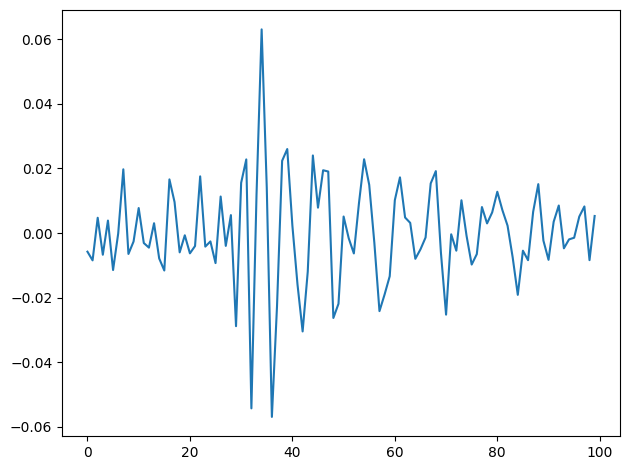

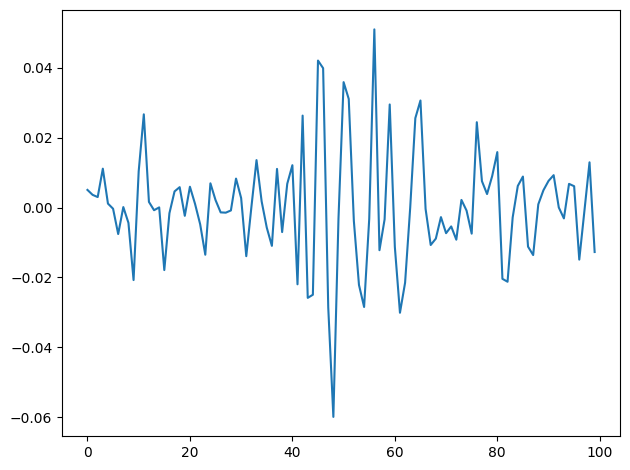

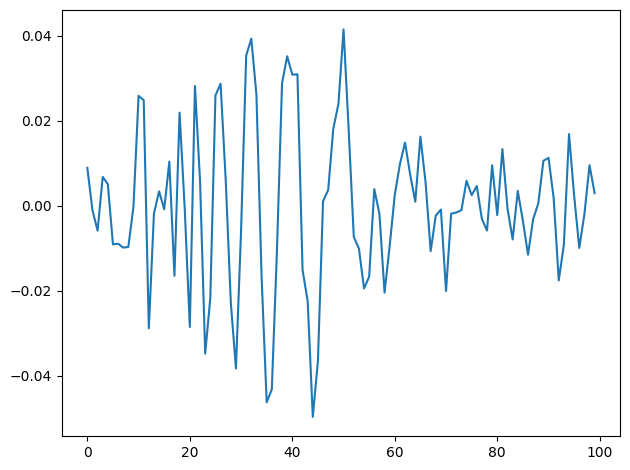

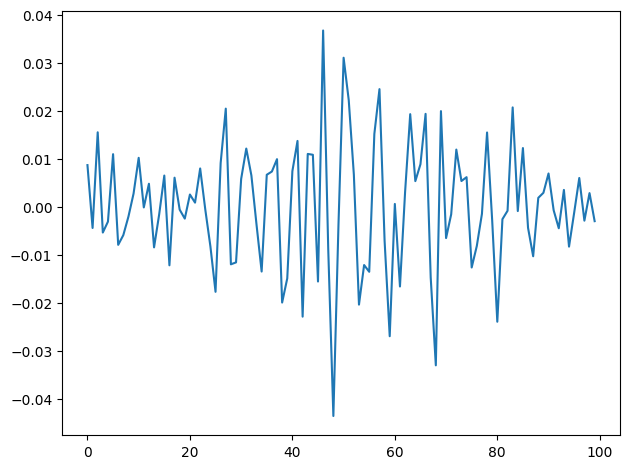

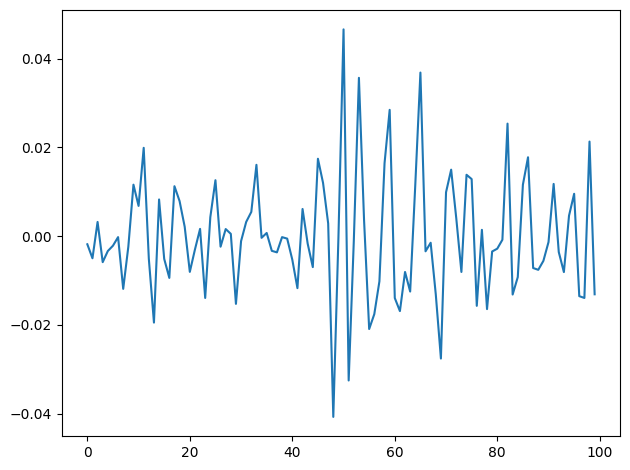

In [9]:
# plot a few signal events
for trace in x[smask][:5]:
  fig, ax = plt.subplots(1, 1)
  ax.plot(trace)
  fig.tight_layout()
  plt.show()

In [13]:
n_test = 200000

data_test = x[-n_test:-1]
labels_test = y[-n_test:-1]

data_train = x[:-n_test]
labels_train = y[:-n_test]

print(f"{len(labels_train)} event in training/validation data set")
print(data_train.shape)
print(labels_train.shape)
sample_size = len(data_train[0])

399997 event in training/validation data set
(399997, 100)
(399997,)


In [17]:
model = Sequential()
model.add(Flatten(input_shape=(sample_size, 1)))
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])
model.summary()

checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join('saved_models', "model_best.keras"),
                                                   monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True, mode='auto',
                             save_weights_only=False)
#csv_logger = keras.callbacks.CSVLogger(os.path.join('saved_models', "model_history_log.csv"), append=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,121 (43.44 KB)

 Trainable params: 11,121 (43.44 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(x=data_train, y=labels_train, batch_size=32, validation_split=0.2, epochs=200,
          callbacks=[checkpoint, early_stopping])

Epoch 1/200
 9986/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8717 - loss: 0.3745
Epoch 1: val_accuracy improved from -inf to 0.96539, saving model to saved_models/model_best.keras
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8718 - loss: 0.3744 - val_accuracy: 0.9654 - val_loss: 0.1090
Epoch 2/200
 9965/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9733 - loss: 0.0856
Epoch 2: val_accuracy improved from 0.96539 to 0.98368, saving model to saved_models/model_best.keras
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9733 - loss: 0.0855 - val_accuracy: 0.9837 - val_loss: 0.0526
Epoch 3/200
 9986/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0455
Epoch 3: val_accuracy improved from 0.98368 to 0.98895, saving model to saved_models/model_best.keras
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9869 - loss: 0.0455 - val_accuracy: 0.9890 - val_loss: 0.0394
Epoch 4/200
 9988/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [23]:
get_flops(model)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


22131

In [24]:
model2 = Sequential()
model2.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(sample_size, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 98, 16)              │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 49, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             785 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 849 (3.32 KB)

 Trainable params: 849 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model2.fit(x=data_train, y=labels_train, batch_size=32, validation_split=0.2, epochs=200,
          callbacks=[checkpoint, early_stopping])

Epoch 1/200
 9980/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8366 - loss: 0.4454
Epoch 1: val_accuracy did not improve from 0.99586
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.8366 - loss: 0.4452 - val_accuracy: 0.8866 - val_loss: 0.2827
Epoch 2/200
 9996/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9002 - loss: 0.2482
Epoch 2: val_accuracy did not improve from 0.99586
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9002 - loss: 0.2482 - val_accuracy: 0.9385 - val_loss: 0.1656
Epoch 3/200
 9991/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9462 - loss: 0.1474
Epoch 3: val_accuracy did not improve from 0.99586
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9462 - loss: 0.1473 - val_accuracy: 0.9666 - val_loss: 0.1055
Epoch 4/200
 9998/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.0945
Epoch 4: val_accuracy did not improve from 0.99586
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9687 -

In [26]:
get_flops(model2)

14113